In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="ticks", context="notebook")

In [2]:
# Discover and load prediction CSVs
from pathlib import Path

def find_results_dir(start: Path = Path.cwd()) -> Path:
    # Walk up until we find the repo folder that contains Prediction_Results
    for p in [start] + list(start.parents):
        cand = p / 'Prediction_Results'
        if cand.exists() and cand.is_dir():
            return cand
    raise FileNotFoundError("Could not locate 'Prediction_Results' directory by walking up from current path.")

results_dir = find_results_dir()

csv_files = sorted(results_dir.glob('*_bind.csv'))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {results_dir}")

csv_files

[WindowsPath('d:/Github/llm-drug-agent/Prediction_Results/GBM_predictions_bind.csv'),
 WindowsPath('d:/Github/llm-drug-agent/Prediction_Results/Linear_Regression_predictions_bind.csv'),
 WindowsPath('d:/Github/llm-drug-agent/Prediction_Results/MLP_predictions_bind.csv'),
 WindowsPath('d:/Github/llm-drug-agent/Prediction_Results/Random_Forest_predictions_bind.csv'),
 WindowsPath('d:/Github/llm-drug-agent/Prediction_Results/SVR_predictions_bind.csv'),
 WindowsPath('d:/Github/llm-drug-agent/Prediction_Results/XGBoost_predictions_bind.csv')]

In [3]:
# Load and standardize columns: Affinity (true), Predicted (prediction), and Split
from typing import Tuple, List

ID_COLS = ['Index_ID','Drug_ID','Target_ID']


def standardize_df(df: pd.DataFrame) -> pd.DataFrame:
    # Clean up column names: strip whitespace and unify multiple spaces
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    cols = {c.lower(): c for c in df.columns}
    # Prefer explicit columns (case-insensitive)
    true_col = cols.get('affinity')
    pred_col = cols.get('predicted')
    split_col = cols.get('split')
    # Fallbacks if needed
    if true_col is None:
        for c in ['true', 'y_true', 'label', 'affinity_true']:
            if c in cols:
                true_col = cols[c]
                break
    if pred_col is None:
        for c in ['y_pred', 'pred', 'prediction', 'affinity_pred']:
            if c in cols:
                pred_col = cols[c]
                break
    if split_col is None:
        for c in ['set', 'fold', 'partition']:
            if c in cols:
                split_col = cols[c]
                break
    if true_col is None or pred_col is None:
        raise ValueError(f"Expected columns 'Affinity' (true) and 'Predicted' (prediction) not found. Got: {list(df.columns)}")
    out = df.rename(columns={true_col: 'y_true', pred_col: 'y_pred'})
    if split_col and split_col in out.columns:
        out = out.rename(columns={split_col: 'Split'})
    else:
        # No Unknown category requested; use NaN when Split is missing
        out['Split'] = np.nan
    # Keep optional metadata columns if present
    keep_extra = [c for c in ID_COLS if c in out.columns]
    return out[['y_true', 'y_pred', 'Split'] + keep_extra]

# Load all files into a tidy dataframe with model name inferred from filename
frames = []
for f in csv_files:
    df = pd.read_csv(f)
    std = standardize_df(df)
    std['model'] = f.stem.replace('_predictions', '')
    frames.append(std)

all_preds = pd.concat(frames, ignore_index=True)
# Filter to allowed splits only (no Unknown)
allowed_splits = ['Train', 'Validation', 'Test']
all_preds = all_preds[all_preds['Split'].isin(allowed_splits)].copy()
# Ensure Split is categorical with a preferred order
all_preds['Split'] = pd.Categorical(all_preds['Split'], categories=allowed_splits, ordered=True)
all_preds.head()

,y_true,y_pred,Split,Index_ID,Drug_ID,Target_ID,model
0,6.387216,6.129975,Train,Bind19532,16038120.0,Q15835,GBM_bind
1,9.000000,6.349350,Train,Bind17639,11656518.0,Q96GD4,GBM_bind
2,7.251812,6.196449,Train,Bind28381,121426277.0,O00329,GBM_bind
3,7.207608,5.722830,Train,Bind33387,132569638.0,P38919,GBM_bind
4,5.000000,5.808096,Train,Bind36617,25126798.0,P07333,GBM_bind


In [4]:
# Compute metrics per model AND per split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr


def compute_metrics(df: pd.DataFrame) -> dict:
    y_true = df['y_true'].astype(float)
    y_pred = df['y_pred'].astype(float)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    if y_true.nunique() > 1 and y_pred.nunique() > 1:
        pearson = pearsonr(y_true, y_pred)[0]
        spearman = spearmanr(y_true, y_pred)[0]
    else:
        pearson = np.nan
        spearman = np.nan
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Pearson': pearson,
        'Spearman': spearman,
    }

metrics_rows = []
for (name, split), g in all_preds.groupby(['model','Split']):
    row = {'model': name, 'Split': split}
    row.update(compute_metrics(g))
    metrics_rows.append(row)

metrics_df = pd.DataFrame(metrics_rows).sort_values(by=['Split','MAE','RMSE'])
metrics_df.reset_index(drop=True, inplace=True)
metrics_df

C:\Users\Cindy\AppData\Local\Temp\ipykernel_12420\163650798.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (name, split), g in all_preds.groupby(['model','Split']):


,model,Split,MAE,MSE,RMSE,R2,Pearson,Spearman
0,XGBoost_bind,Test,0.549172,0.670283,0.818708,0.641445,0.800949,0.734545
1,GBM_bind,Test,0.731518,1.021746,1.010814,0.453436,0.686024,0.633379
2,Random_Forest_bind,Test,0.950174,1.952190,1.397208,-0.044287,0.189581,0.196945
3,Linear_Regression_bind,Test,1.220510,1.968563,1.403055,-0.053046,0.251804,0.224522
4,SVR_bind,Test,1.229780,1.974960,1.405333,-0.056468,0.387257,0.400511
5,MLP_bind,Test,3.180183,11.933495,3.454489,-5.383597,0.161342,0.130412
6,XGBoost_bind,Train,0.353682,0.265792,0.515550,0.859641,0.930245,0.862229
7,GBM_bind,Train,0.717069,0.977317,0.988594,0.483899,0.713162,0.663857
8,Random_Forest_bind,Train,0.962513,1.981699,1.407728,-0.046494,0.174478,0.185802
9,Linear_Regression_bind,Train,1.218861,1.979306,1.406878,-0.045231,0.270204,0.236268


In [5]:
metrics_df.to_csv('./model_evaluation_metrics_by_split_Bind.csv', index=False)

WindowsPath('d:/Github/llm-drug-agent/Evaluation_Metrics/figures/pred_vs_true_scatter_by_model_hue_split_Bind.png')

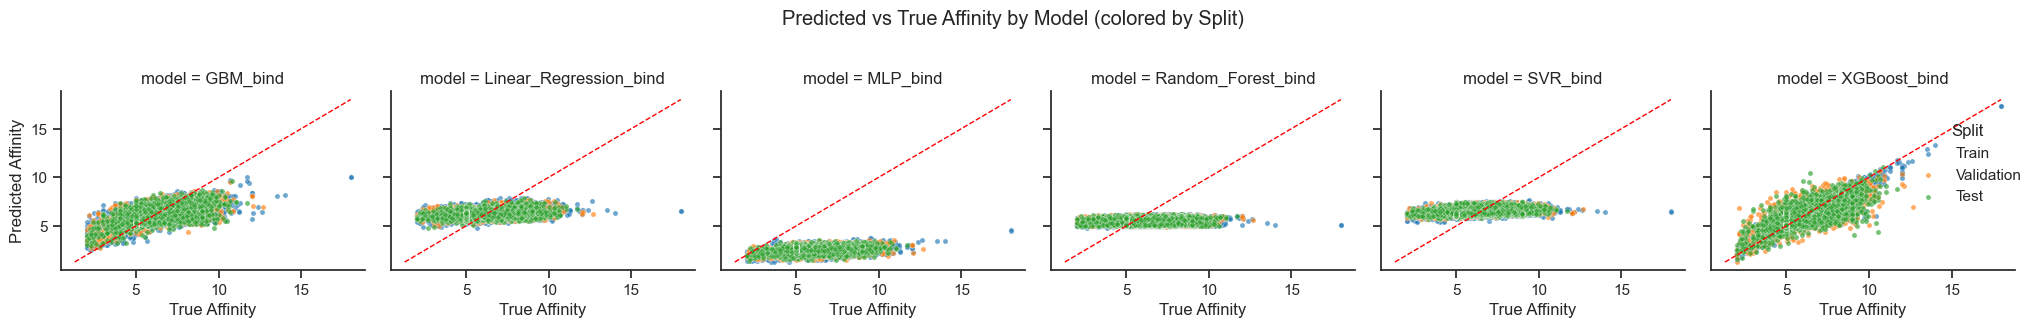

In [6]:
# Scatter plots: Predicted vs True per model, colored by Split (one subplot per model)
fig_dir = results_dir.parent / 'Evaluation_Metrics' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

# Determine splits present and build a safe palette
splits_present = [s for s in pd.Series(all_preds['Split']).astype(str).dropna().unique().tolist()]
palette_base = {
    'Train': '#1f77b4',
    'Validation': '#ff7f0e',
    'Test': '#2ca02c',
    'Unknown': '#7f7f7f',
}
palette = {k: palette_base.get(k, '#7f7f7f') for k in splits_present}

# Facet by Model; color by Split
g = sns.FacetGrid(all_preds, col="model", sharex=True, sharey=True, height=3.2, margin_titles=True, hue="Split", palette=palette)
g.map_dataframe(sns.scatterplot, x='y_true', y='y_pred', s=14, alpha=0.65)

# Add y=x line to each facet
min_v = np.nanmin(all_preds[['y_true','y_pred']].values)
max_v = np.nanmax(all_preds[['y_true','y_pred']].values)
for ax in g.axes.flatten():
    ax.plot([min_v, max_v], [min_v, max_v], ls='--', c='red', lw=1)
    ax.set_xlabel('True Affinity')
    ax.set_ylabel('Predicted Affinity')

# Add legend once
g.add_legend(title='Split')

g.fig.suptitle('Predicted vs True Affinity by Model (colored by Split)', y=1.02)
plt.tight_layout()
scatter_path = fig_dir / 'pred_vs_true_scatter_by_model_hue_split_Bind.png'
plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
scatter_path

WindowsPath('d:/Github/llm-drug-agent/Evaluation_Metrics/figures/residuals_boxplot_by_split_Bind.png')

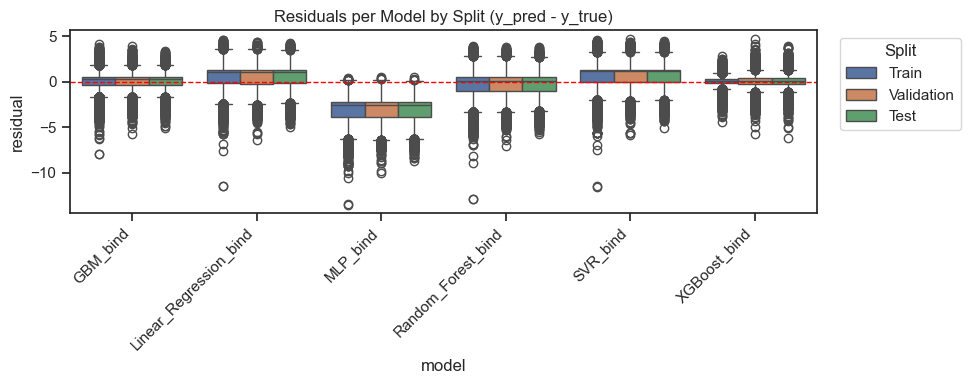

In [7]:
# Residual box plot per model and split
all_preds['residual'] = all_preds['y_pred'] - all_preds['y_true']

plt.figure(figsize=(10, 4))
sns.boxplot(data=all_preds, x='model', y='residual', hue='Split')
plt.axhline(0, ls='--', c='red', lw=1)
plt.xticks(rotation=45, ha='right')
plt.title('Residuals per Model by Split (y_pred - y_true)')
plt.legend(title='Split', bbox_to_anchor=(1.02, 1), loc='upper left')
box_path = fig_dir / 'residuals_boxplot_by_split_Bind.png'
plt.tight_layout()
plt.savefig(box_path, dpi=300)
box_path

## Metrics summary
The table below summarizes error and correlation metrics per model. Lower MAE/RMSE and higher R2/Correlations are better.

In [9]:
# Show metrics
metrics_df

,model,Split,MAE,MSE,RMSE,R2,Pearson,Spearman
0,XGBoost_davis,Test,0.367102,0.351971,0.593271,0.507417,0.712593,0.604423
1,Random_Forest_davis,Test,0.417401,0.882236,0.939274,-0.234688,0.093017,0.143346
2,GBM_davis,Test,0.418672,0.448684,0.669838,0.372068,0.615522,0.549583
3,SVR_davis,Test,0.430413,0.819536,0.905282,-0.146940,0.421264,0.426838
4,Linear_Regression_davis,Test,0.454266,0.817489,0.904151,-0.144075,0.432861,0.420689
5,MLP_davis,Test,3.342348,11.861262,3.444018,-15.599819,0.220478,0.233192
6,XGBoost_davis,Train,0.171624,0.064358,0.253688,0.906806,0.956779,0.762788
7,GBM_davis,Train,0.387668,0.372827,0.610596,0.460126,0.689871,0.591854
8,Random_Forest_davis,Train,0.409651,0.851127,0.922566,-0.232479,0.114517,0.145579
9,SVR_davis,Train,0.422002,0.784932,0.885964,-0.136625,0.454396,0.445580
